In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.pipeline import Pipeline

# Импортируем кастомный трансформер
from custom_preprocessor import TextPreprocessor

warnings.filterwarnings('ignore')

Обучение модели...
F1-Score (spam): 0.9362
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



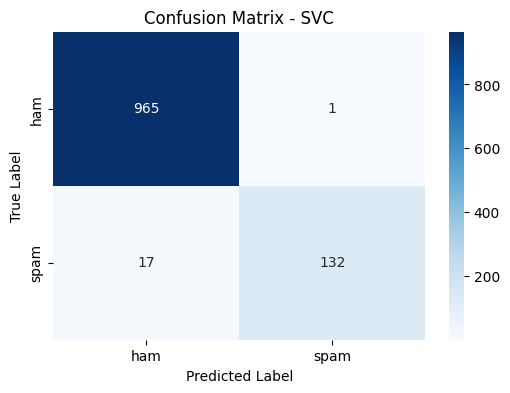

Сохранено: единый sklearn-pipeline -> spam_classifier.joblib
Демонстрация работы модели:
Сообщение: Free entry in 2 a wkly comp to win FA Cup final tkts
Предсказание: spam
Вероятность спама: 0.9834
Вероятность не спама: 0.0166
Обработанный текст: free entri wkli comp win cup final tkt
--------------------------------------------------
Сообщение: Hey, are we still meeting for lunch tomorrow?
Предсказание: ham
Вероятность спама: 0.0007
Вероятность не спама: 0.9993
Обработанный текст: hey still meet lunch tomorrow
--------------------------------------------------
Сообщение: URGENT: Your bank account has been suspended. Verify your details now.Congratulations! You've won a $1000 gift card. Click here to claim.
Предсказание: spam
Вероятность спама: 0.8790
Вероятность не спама: 0.1210
Обработанный текст: urgent bank account suspend verifi detail now.congratul 've 1000 gift card click claim
--------------------------------------------------
Сообщение: Ok, see you later then
Предсказание: ham

In [32]:
# Загрузка данных
def load_data(filepath):
    df = pd.read_csv(filepath, encoding='latin-1')
    df = df.rename(columns={'v1': 'target', 'v2': 'text'})
    df = df[['target', 'text']]
    return df

# Обучение модели с единым пайплайном
def train_and_save_model():
    # Загрузка данных
    df = load_data('spam.zip')
    
    X_raw = df['text']
    y = df['target']
    
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y, test_size=0.2, random_state=42, stratify=y
    )
    
    pipeline = Pipeline([
        ("preprocessor", TextPreprocessor()),
        ("vectorizer", TfidfVectorizer(
            max_features=3000,
            min_df=2,
            max_df=0.8,
            ngram_range=(1, 3)
        )),
        ("classifier", SVC(
            random_state=42, 
            probability=True
        )),
    ])
    
    # Обучение
    print("Обучение модели...")
    pipeline.fit(X_train, y_train)
    
    # Оценка
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label='spam')
    
    print(f"F1-Score (spam): {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Визуализация
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    plt.title('Confusion Matrix - SVC')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Сохраняем ЕДИНЫЙ пайплайн
    joblib.dump(pipeline, "spam_classifier.joblib")
    print("Сохранено: единый sklearn-pipeline -> spam_classifier.joblib")
    
    return pipeline

def load_model_and_predict(message):
    try:
        pipeline = joblib.load('spam_classifier.joblib')
    except FileNotFoundError:
        print("Файл модели не найден. Сначала обучите модель.")
        return None
    
    proba = pipeline.predict_proba([message])[0]
    pred = pipeline.predict([message])[0]
    
    classes = list(pipeline.named_steps['classifier'].classes_)
    spam_idx = classes.index('spam')
    ham_idx = classes.index('ham')
    
    processed_text = preprocess_text(message)
    
    return {
        'prediction': pred,
        'spam_probability': float(proba[spam_idx]),
        'ham_probability': float(proba[ham_idx]),
        'processed_text': processed_text
    }

# Демонстрация
def demo_predictions():
    test_messages = [
        "Free entry in 2 a wkly comp to win FA Cup final tkts",
        "Hey, are we still meeting for lunch tomorrow?",
        "URGENT: Your bank account has been suspended. Verify your details now."
        "Congratulations! You've won a $1000 gift card. Click here to claim.",
        "Ok, see you later then"
    ]
    
    print("Демонстрация работы модели:")
    print("=" * 50)
    
    for msg in test_messages:
        result = load_model_and_predict(msg)
        if result:
            print(f"Сообщение: {msg}")
            print(f"Предсказание: {result['prediction']}")
            print(f"Вероятность спама: {result['spam_probability']:.4f}")
            print(f"Вероятность не спама: {result['ham_probability']:.4f}")
            print(f"Обработанный текст: {result['processed_text']}")
            print("-" * 50)

# Основная функция
if __name__ == "__main__":
    # Обучаем и сохраняем модель
    model = train_and_save_model()
    
    # Демонстрация работы
    demo_predictions()
    
    # Тестовое сообщение
    test_message = "Free money! Claim your prize now!"
    result = load_model_and_predict(test_message)
    
    if result:
        print(f"\nРезультат для тестового сообщения:")
        print(f"Сообщение: {test_message}")
        print(f"Предсказание: {result['prediction']}")
        print(f"Вероятность спама: {result['spam_probability']:.4f}")
        print(f"Вероятность не спама: {result['ham_probability']:.4f}")
